Домашняя работа. Условие: [https://https://docs.google.com/document/d/1oTOU5FKyvqKIwvN_MnMrL6fj8mWDu7bbuL_t7EZGXHM/edit](https://https://docs.google.com/document/d/1oTOU5FKyvqKIwvN_MnMrL6fj8mWDu7bbuL_t7EZGXHM/edit)

In [148]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
%matplotlib inline

# Данные

## Подготовка данных (задание 1)

Скачиваем данные из https://ourworldindata.org/coronavirus-source-data  
Затем выбираем данные для России старше 3 марта 2020 года

In [44]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2022-03-07 22:00:00--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.2’

owid-covid-data.csv     [  <=>               ]  45.30M   159MB/s    in 0.3s    

2022-03-07 22:00:00 (159 MB/s) - ‘owid-covid-data.csv.2’ saved [47496896]



In [45]:
start_date = datetime.datetime(2020, 3, 3)


data = pd.read_csv('owid-covid-data.csv')
data = data[(data.location == 'Russia') & (data.date >= str(start_date))]
print('Количество данных', data.shape)
print(f'Минимальная дата: {data.date.min()}, максимальная дата: {data.date.max()}')
print(f'Минимальное кол-во заболевших: {data.total_cases.min()}, максимальное кол-во заболевших: {data.total_cases.max()}')
data.head()

Количество данных (733, 67)
Минимальная дата: 2020-03-04, максимальная дата: 2022-03-06
Минимальное кол-во заболевших: 3.0, максимальное кол-во заболевших: 16698139.0


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123956,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123957,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123958,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123959,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123960,RUS,Europe,Russia,2020-03-08,17.0,4.0,2.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


## Данные для моделирования (задание 1)

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases). 
Зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта (данные начинаются с 4го марта). 
Для упрощения обработки заменим в столбце new_cases все нули на единицы.

In [54]:
data['new_cases'] = data['new_cases'].replace(0, 1)
data = data.sort_values('date').reset_index()
train_indices = data[(data.date >= '2020-03-03') & (data.date < str(start_date + datetime.timedelta(days=50)))].index

In [55]:
assert (data.date.value_counts() > 1).sum() == 0, 'Есть строки с одинаковой датой'
assert ((pd.to_datetime(data.date).dt.date - pd.to_datetime(data.date).shift(1).dt.date).dt.days > 1).sum() == 0, 'Есть пропуски дат'

# Моделирование

## Визуализация целевых переменных (задание 2)

Построим графики целевых переменных:

In [56]:
targets = ['total_cases', 'new_cases']

In [57]:
plot_data = data[targets + ['date']].copy()
plot_data = plot_data.set_index('date')

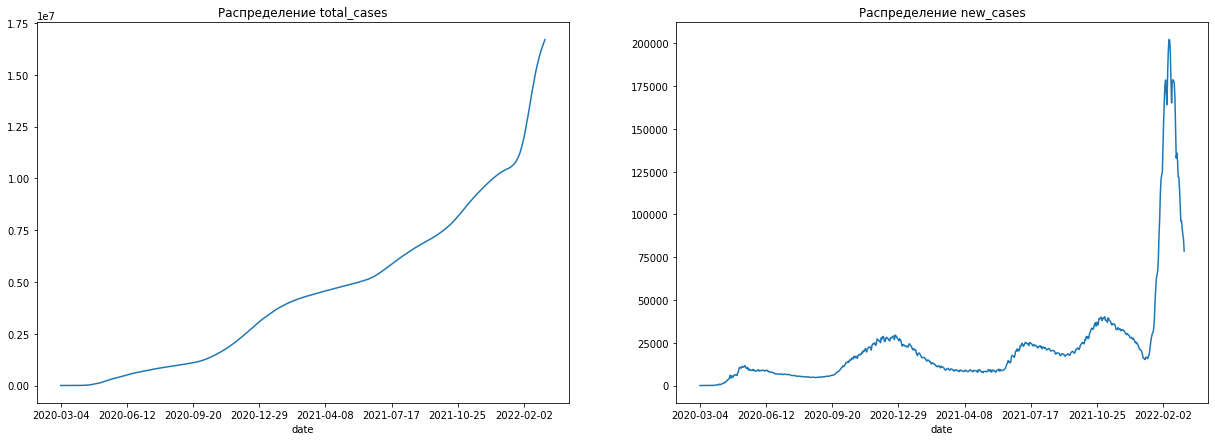

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

plot_data[targets[0]].plot(title=f'Распределение {targets[0]}', ax=axes[0])
plot_data[targets[1]].plot(title=f'Распределение {targets[1]}', ax=axes[1])

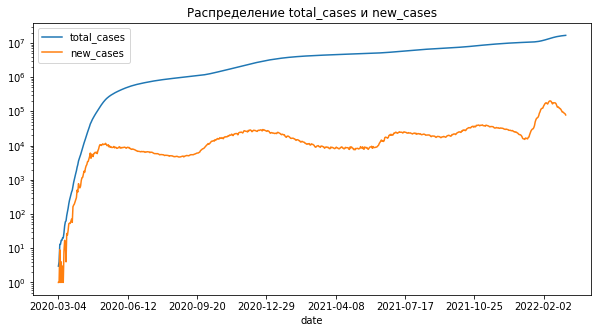

In [59]:
plot_data[targets].plot(title=f'Распределение {targets[0]} и {targets[1]}', figsize=(10, 5), logy=True)

Да, действительно, распределение количества заболевших имеет сходство с экпонентой или степенной функцией (возрастает быстро и выходит на плато). Прирост кол-ва заболевших, в свою очередь, более явно показывает волны, мы очтётливо видим 5 волн короны.

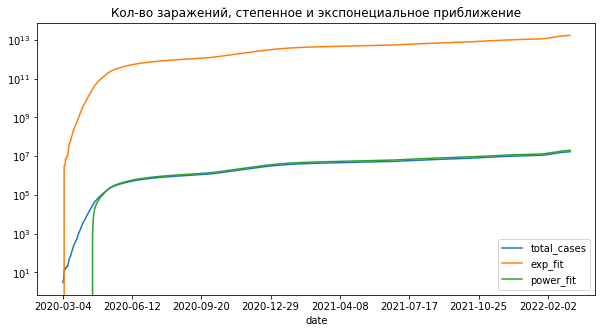

In [60]:
a1, b1 = np.polyfit(np.log(data[targets[0]]), data[targets[0]], 1)
a2, b2 = np.polyfit(np.power(data[targets[0]], 1 - 0.01), data[targets[0]], 1)

plot_data['exp_fit'] = (a1 * data[targets[0]] + b1).tolist()
plot_data['power_fit'] = (a2 * data[targets[0]] + b2).tolist()
plot_data[[targets[0], 'exp_fit', 'power_fit']].plot(title=f'Кол-во заражений, степенное и экспонециальное приближение', figsize=(10, 5), logy=True)
del a1, b1, a2, b2, plot_data

К счастью, мы уже заранее знаем, что рост не будет продолжаться вечно, поэтому мы сразу можем сказать, что кол-во заболевших от продолжительности эпидемии имеет не экпоненциальную зависимость.

## Разбивка не трейн и тест

In [77]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
data['duration_in_days'] = (data.index.values + 1).tolist()
train = data.loc[train_indices].copy()
test = data[~data.index.isin(train.index)].copy()
assert train.shape[0] == 50, 'Трейн не 50 дней'
assert train.shape[0] + test.shape[0] == data.shape[0], 'неправильный трейн или тест'

## Линейная регрессия. Экспонента (задание 2a)

Используя линейную регрессию, обучаем модель с экспоненциальным ростом числа заболевших: y = exp(f(x)) -> ln(y) = f(x)

In [254]:
target = targets[0]
features = ['duration_in_days']

In [255]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
x_train = train[features].values
y_train = train[target].values
y_train_log = np.log(y_train)

lr = LinearRegression().fit(x_train, y_train_log)

data[f'prediction_{target}'] = np.exp(lr.predict(data[features].values)).tolist()
print(f'Наклон: {lr.coef_}, смещение {lr.intercept_}')

Наклон: [0.1947175], смещение 1.9109596753423403


Только на логарифмическом масштабе можно рассмотреть, что на тесте ошибка становится очень большой. Мы как раз обучились на экпоненциальном росте, что и привело к такой ошибке (ну или, если точнее, то, что мы неправильно выбрали подходящую функцию, которая не описывает реальную зависимость)

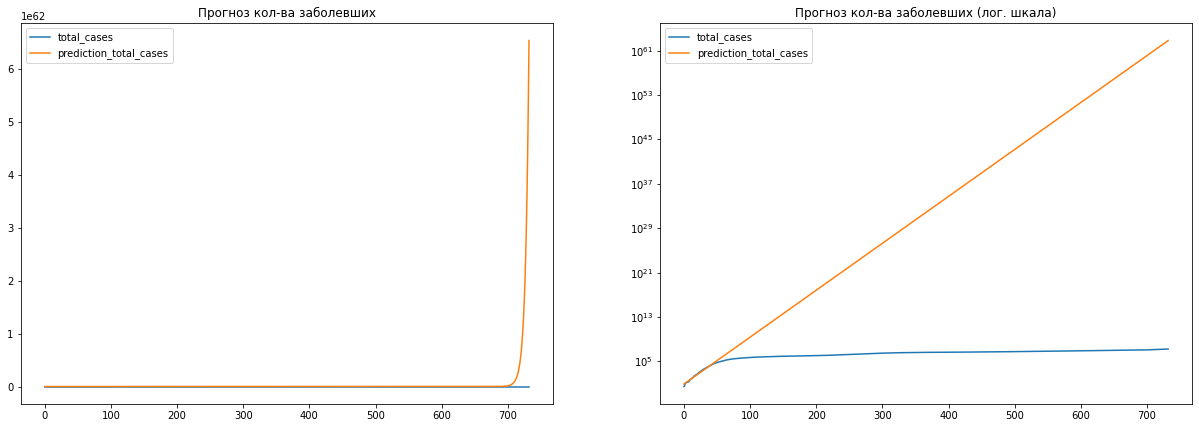

In [256]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

data[[target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших', ax=axes[0])
data[[target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших (лог. шкала)', logy=True, ax=axes[1])

При более крупном масштабе это более нагляден переход, когда начинается расхождение предсказаний и реальныз данных

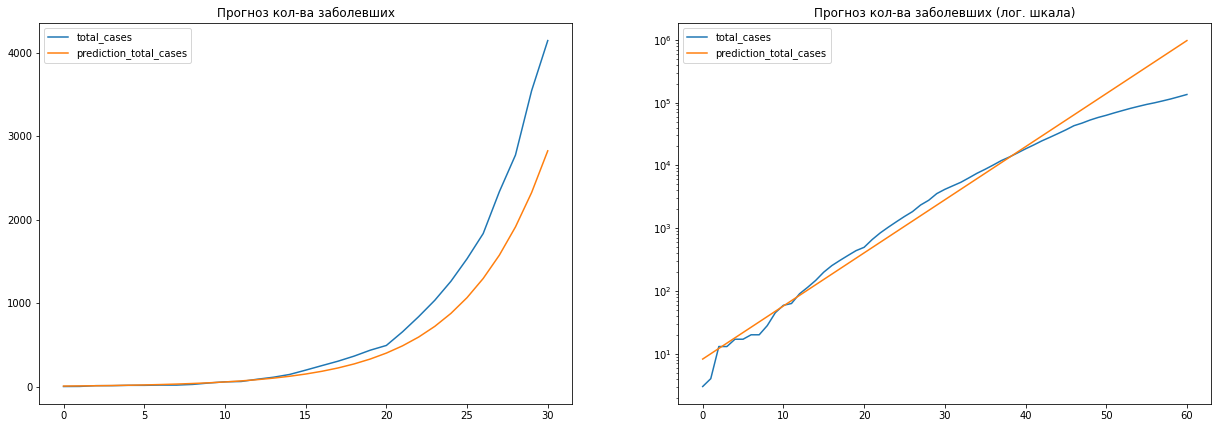

In [257]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

ax = data.loc[:30, [target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших', ax=axes[0])
data.loc[:60, [target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших (лог. шкала)', logy=True, ax=axes[1])

##  Апостериорное распределение параметров модели для достаточно широкого априорного распределения (задание 2b)

In [258]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, *x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [261]:
sigma_noise = np.sqrt((y_train_log - lr.predict(x_train)).var())

cur_mu, cur_sigma = np.array([0, 0]), 2 * np.array([[1, 0, ], [0, 1, ]])

for i in range(x_train.shape[0]):
    px, py = x_train[i], y_train_log[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise)

print(f'mu {cur_mu}, sigma {cur_sigma}')
print(f'Уравнение линейной регресии           : {lr.coef_[0]} * x + {lr.intercept_}')
print(f'Апостериорное распределение параметров: {cur_mu[1]} * x + {cur_mu[0]}')

mu [1.90154166 0.19499697], sigma [[ 9.88677121e-03 -2.93666059e-04]
 [-2.93666059e-04  1.15301944e-05]]
Уравнение линейной регресии           : 0.19471749807287067 * x + 1.9109596753423403
Апостериорное распределение параметров: 0.19499696750615847 * x + 1.9015416557562723


## Сэмплы разных экспанент (задание 2с)

In [95]:
preds = []
dates = []

for year in [2020, 2021, 2022]:
    for month in [5, 6, 9]:
        dates.append((datetime.datetime(year, month, 1) - start_date).days)

for i in range(1000):
    pred = []
    for dt in dates:
        w1, w0 = np.random.multivariate_normal(mu, cov)
        pred.append(np.exp(w1 * dt + w0))
    preds.append(pred)
plt.show()

In [96]:
print("1 мая 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 0]))))
print("1 июня 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 1]))))
print("1 сентября 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 2]))))
print("1 мая 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 3]))))
print("1 июня 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 4]))))
print("1 сентября 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 5]))))
print("1 мая 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 6]))))
print("1 июня 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 7]))))
print("1 сентября 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 8]))))


1 мая 2020 предсказывается кол-во заболевших: 1187065
1 июня 2020 предсказывается кол-во заболевших: 1017981916
1 сентября 2020 предсказывается кол-во заболевших: 561811473517883456
1 мая 2021 предсказывается кол-во заболевших: 70349157373515762563063750111605882355712
1 июня 2021 предсказывается кол-во заболевших: 70210337517762576498365667991161331418923008
1 сентября 2021 предсказывается кол-во заболевших: 49889061997142136442826964106970452132247858952798208
1 мая 2022 предсказывается кол-во заболевших: 10838581909070739225151681206912835813401261815840863354742330104435687030784
1 июня 2022 предсказывается кол-во заболевших: 9461805981323382659048752004569775329388191367324413667420912090752825029558272
1 сентября 2022 предсказывается кол-во заболевших: 10590822606786653175263318843727290986425156526240780683771015124457907808839971561799680


В целом, мы выше уже видели, что экспоненциальный рост, по видению модели, будет продолжаться вечно, и в 2020 году уже должны были заболеть все люди, а в 2022 вообще все живые существа и по несколько раз. Экстраполяция даёт нам печальные результаты.

## Линейная регрессия. Сигмоида (задание 3)

total_cases - это куммулятивная сумма поля new_cases. Мы можем моделировать new_cases функцией плотности гауссианы. Для этого необходимо с помощью линейной регрессии обучить логарифм new_cases квадратичной функцией.

Для решения проблемы с экпоненциальным ростом мы можем обучать следующую линейную регрессию: ln(y) = a * x^2 + b * x + c, только y, в данном случае, - прирост, а не количество заболевших.

In [155]:
target = targets[1]

data['day_number'] = data.index.values + 1
data['day_number_pow2'] = np.power(data.index.values + 1, 2)

train = data.loc[train_indices].copy()
test = data[~data.index.isin(train.index)].copy()
assert train.shape[0] == 50, 'Трейн не 50 дней'
assert train.shape[0] + test.shape[0] == data.shape[0], 'неправильный трейн или тест'

In [156]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
x_train = train[['day_number', 'day_number_pow2']].values

y_train = train[target].values
y_train_log = np.log(y_train)

lr = LinearRegression().fit(x_train, y_train_log)

data[f'prediction_{target}'] = np.exp(lr.predict(data[['day_number', 'day_number_pow2']].values)).tolist()
data[f'prediction_{target}_cumsum'] = data[f'prediction_{target}'].cumsum()

print(f'Уравнение: {lr.coef_[0]} * x + {lr.coef_[1]} * x^2 + {lr.intercept_}')
true_mu = [lr.intercept_, lr.coef_[0], lr.coef_[1]]

Уравнение: 0.28402042878254774 * x + -0.001986790036813083 * x^2 + -0.4888121596256143


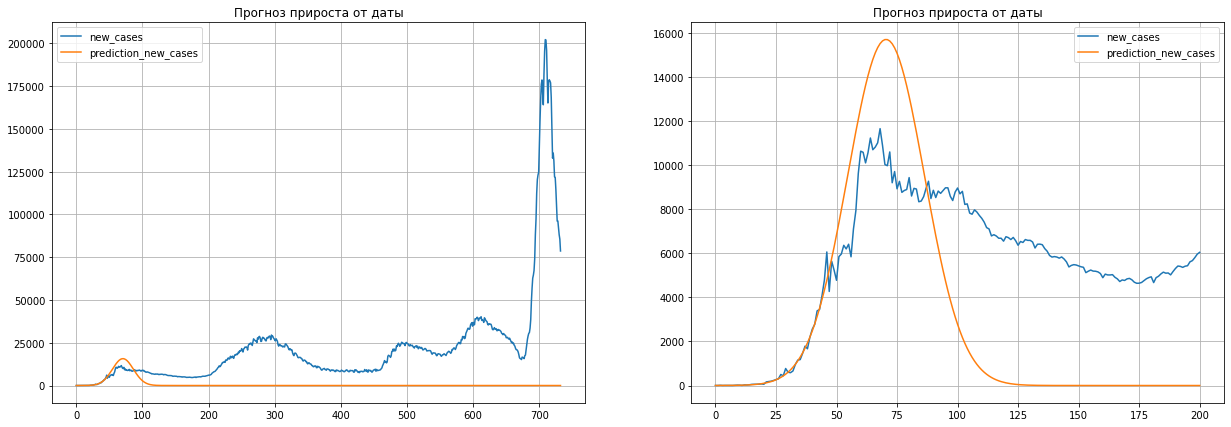

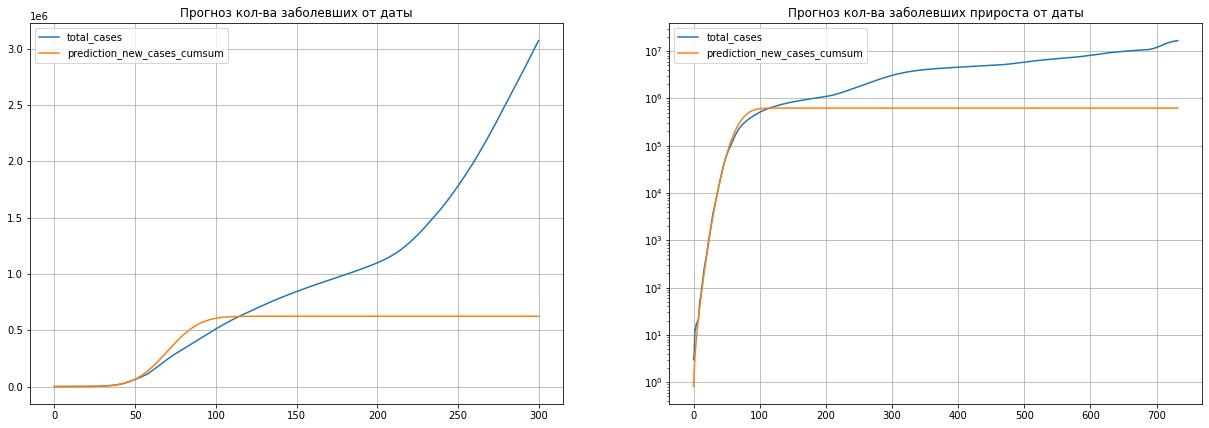

In [157]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

data[[target, f'prediction_{target}']].plot(title='Прогноз прироста от даты', ax=axes[0], grid=True)
data.loc[:200, [target, f'prediction_{target}']].plot(title='Прогноз прироста от даты', ax=axes[1], grid=True)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

data.loc[:300, [targets[0], f'prediction_{target}_cumsum']].plot(title='Прогноз кол-ва заболевших от даты', ax=axes[0], grid=True)
data.loc[:, [targets[0], f'prediction_{target}_cumsum']].plot(title='Прогноз кол-ва заболевших прироста от даты', ax=axes[1], grid=True, logy=True)
plt.show()

Мы наблюдаем, что результаты стали точнее, особенно учитывая, что учились на 50 точках.

In [172]:
sigma_noise = np.sqrt((y_train_log - lr.predict(x_train)).var())

cur_mu, cur_sigma = np.array([0, 0, 0]), 2 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

for i in range(x_train.shape[0]):
    px, py = x_train[i], y_train_log[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_noise)

print(f'mu {cur_mu}, sigma {cur_sigma}')
print(f'Уравнение линейной регресии           : {lr.coef_[0]} * x + {lr.coef_[1]} * x^2 + {lr.intercept_}')
print(f'Апостериорное распределение параметров: {cur_mu[1]} * x + {cur_mu[2]} * x^2 + {cur_mu[0]}')

mu [-0.47728682  0.2830952  -0.00197142], sigma [[ 4.50818926e-02 -3.57010229e-03  5.89112799e-05]
 [-3.57010229e-03  3.70843058e-04 -6.84677841e-06]
 [ 5.89112799e-05 -6.84677841e-06  1.34586322e-07]]
Уравнение линейной регресии           : 0.28402042878254774 * x + -0.001986790036813083 * x^2 + -0.4888121596256143
Апостериорное распределение параметров: 0.2830952037741934 * x + -0.0019714193156589177 * x^2 + -0.4772868214709547


(-500000.0, 9000000.0)

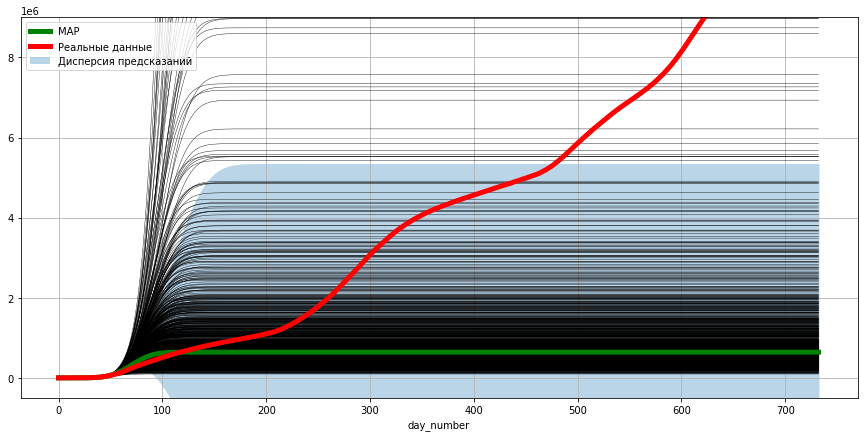

In [239]:
ys = []
for w in np.random.multivariate_normal(cur_mu, cur_sigma, 1000):
    ys.append(np.cumsum(np.exp(w[0] + w[1] * data['day_number'] + w[2] * data['day_number_pow2'])))
for y in ys:
    pd.Series(y, index=data['day_number'])\
    .plot(grid=True, figsize=(15, 7), color='black', lw=0.4, label='_nolegend_')
np.exp((cur_mu[1] * data['day_number'] + cur_mu[2]* data['day_number_pow2'] + cur_mu[0])).cumsum().plot(grid=True, figsize=(15, 7), color='green', lw=5, label='MAP')
ax = data[targets[0]].plot(grid=True, figsize=(15, 7), color='red', lw=5, label='Реальные данные')
ax.fill_between(data['day_number'], np.mean(ys, axis=0) - np.std(ys, axis=0), np.mean(ys, axis=0) + np.std(ys, axis=0), alpha=.3, label='Дисперсия предсказаний')
ax.legend();
ax.set_ylim(-.5e6, 9e6)

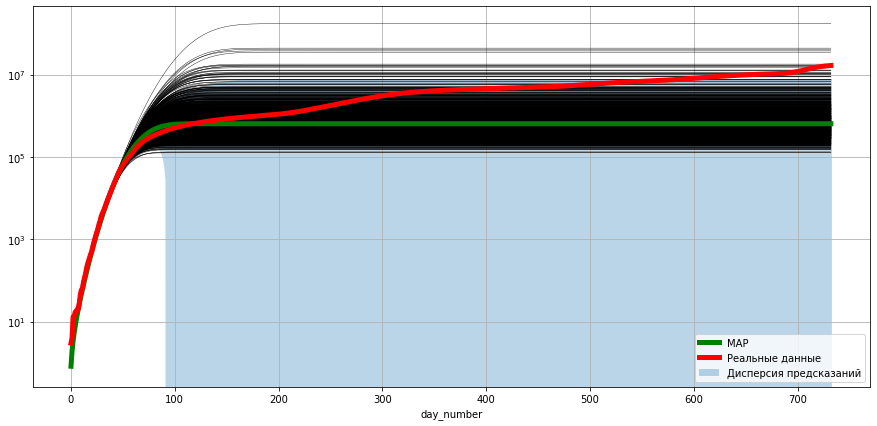

In [240]:
ys = []
for w in np.random.multivariate_normal(cur_mu, cur_sigma, 1000):
    ys.append(np.cumsum(np.exp(w[0] + w[1] * data['day_number'] + w[2] * data['day_number_pow2'])))
for y in ys:
    pd.Series(y, index=data['day_number'])\
    .plot(grid=True, figsize=(15, 7), color='black', lw=0.4, label='_nolegend_')
np.exp((cur_mu[1] * data['day_number'] + cur_mu[2]* data['day_number_pow2'] + cur_mu[0])).cumsum().plot(grid=True, figsize=(15, 7), color='green', logy=True, lw=5, label='MAP')
ax = data[targets[0]].plot(grid=True, figsize=(15, 7), color='red', lw=5, label='Реальные данные', logy=True)
ax.fill_between(data['day_number'], np.mean(ys, axis=0) - np.std(ys, axis=0), np.mean(ys, axis=0) + np.std(ys, axis=0), alpha=.3, label='Дисперсия предсказаний')
ax.legend();

In [253]:
print(f'Текущее кол-во заболевших: {data[targets[0]].iloc[-1]} \nПредсказание: {np.array(ys)[-1, :].mean()} \nПлохой сценарий: {np.quantile(np.array(ys)[-1, :], 0.9)} \nОптимистичный сценарий: {np.quantile(np.array(ys)[-1, :], 0.1)}')

Текущее кол-во заболевших: 16698139.0 
Предсказание: 463700.549871118 
Плохой сценарий: 512149.5088165668 
Оптимистичный сценарий: 311959.8029582536


Мы наблюдаем, что с сигмоидой качество сильно выросло. Даже пессимистичный сценарий оказался оптмистичней реальности (учитывая 5ую волну).

# Другие страны (задание 4)

In [297]:
data_full = pd.read_csv('owid-covid-data.csv')
data_full.location.value_counts()

Argentina       796
Mexico          796
Thailand        793
Taiwan          781
China           775
               ... 
Turkmenistan    183
Tuvalu          179
Niue            157
Tokelau         114
Pitcairn         85
Name: location, Length: 238, dtype: int64

In [302]:
data[data.total_cases > 1].index[0]

165838

In [301]:
data.iloc[:]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,day_number,day_number_pow2
165837,ZWE,Africa,Zimbabwe,2020-03-20,1.0,1.0,NaN,NaN,NaN,NaN,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,165838,27502242244
165838,ZWE,Africa,Zimbabwe,2020-03-21,3.0,2.0,NaN,NaN,NaN,NaN,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,165839,27502573921
165839,ZWE,Africa,Zimbabwe,2020-03-22,3.0,1.0,NaN,NaN,NaN,NaN,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,165840,27502905600
165840,ZWE,Africa,Zimbabwe,2020-03-23,3.0,1.0,NaN,1.0,1.0,NaN,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,165841,27503237281
165841,ZWE,Africa,Zimbabwe,2020-03-24,3.0,1.0,NaN,1.0,0.0,NaN,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,165842,27503568964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,ZWE,Africa,Zimbabwe,2022-03-02,237503.0,632.0,416.286,5396.0,1.0,1.143,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,166550,27738902500
166550,ZWE,Africa,Zimbabwe,2022-03-03,237503.0,1.0,362.286,5396.0,0.0,0.857,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,166551,27739235601
166551,ZWE,Africa,Zimbabwe,2022-03-04,238739.0,1236.0,467.429,5397.0,1.0,0.714,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,166552,27739568704
166552,ZWE,Africa,Zimbabwe,2022-03-05,239019.0,280.0,459.429,5397.0,0.0,0.571,...,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN,166553,27739901809


In [342]:
results = []
target = targets[1]

data_full['day_number'] = data_full.index.values + 1
data_full['day_number_pow2'] = np.power(data_full.index.values + 1, 2)
data_full['new_cases'] = data_full['new_cases'].replace(0, 1).fillna(1)

for country in data_full.location.unique():
    data = data_full[data_full.location == country].sort_values('date').reset_index()
    if data.total_cases.max() > 1e6:
        if (data.total_cases > 3).sum() > 700:
            data = data.iloc[data[data.total_cases > 1].index[0]:]
            
            train = data[data.index < 50]
            if train.shape[0] > 49:
                x_train = train[['day_number', 'day_number_pow2']].values

                y_train = train[target].values
                y_train_log = np.log(y_train)

                lr = LinearRegression().fit(x_train, y_train_log)
                results.append([country, lr.intercept_, lr.coef_[0], lr.coef_[1]])

Попробуем взглянуть на коэффиценты визуально, на смещение пока забудем.

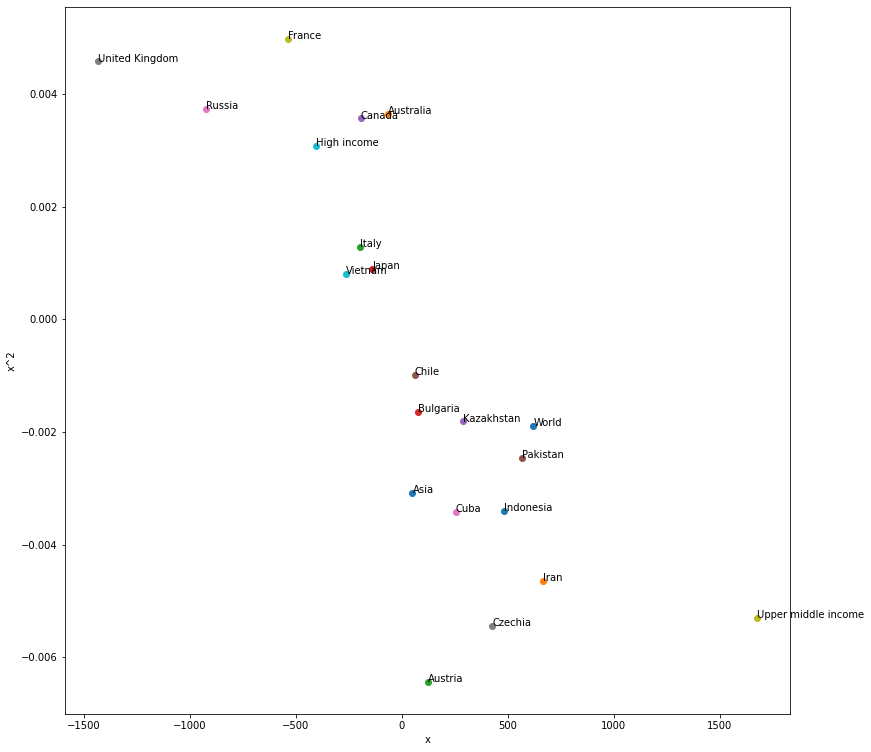

In [343]:
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
ax.set_xlabel("x")
ax.set_ylabel("x^2")

for res in results:
    plt.scatter(res[2], res[3])
    plt.annotate(res[0], (res[2], res[3]))

In [344]:
country_data = pd.DataFrame(results)
country_data.columns = ['cntry', 'intercept', 'x', 'x2']
normalized_country_data = country_data
normalized_country_data[['intercept', 'x', 'x2']] = (country_data[['intercept', 'x', 'x2']] - country_data[['intercept', 'x', 'x2']].mean()) / country_data[['intercept', 'x', 'x2']].std()

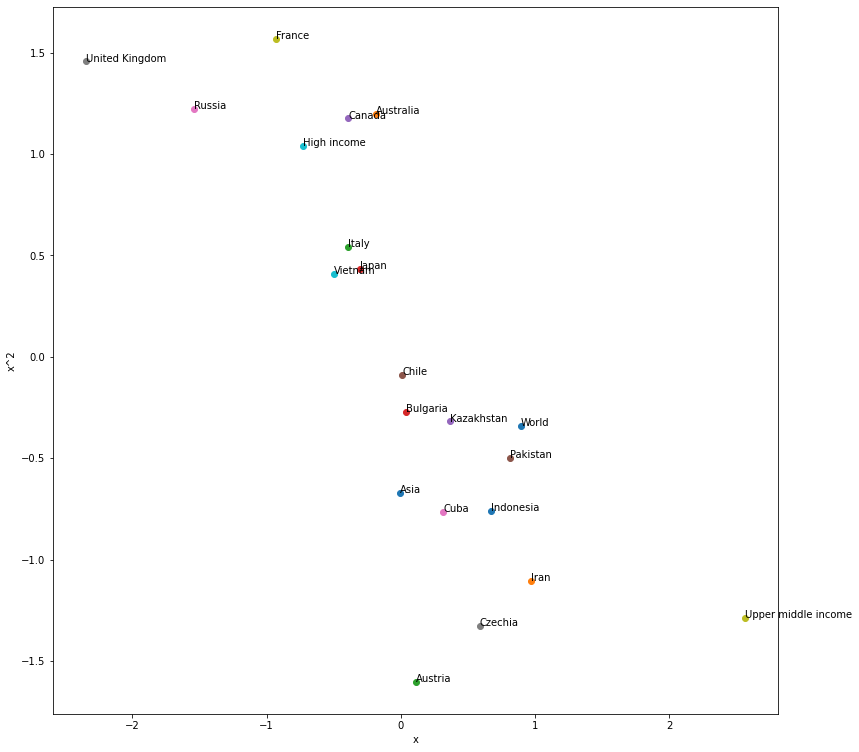

In [345]:
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
ax.set_xlabel("x")
ax.set_ylabel("x^2")

for res in normalized_country_data.iterrows():
    plt.scatter(res[1].x, res[1].x2)
    plt.annotate(res[1].cntry, (res[1].x, res[1].x2))

Визуально кластера плохо видно, но видно, что Китай, Иран, Австрия и т.д. сильно отличаются от остальных.  
Для наглядности оставил только страны с большим числом заболевших: Италия, Япония и Вьетнам находятся рядом, а так же Канада и Австралия (что не удивительно). При этом чем выше доход, тем меньше скорость заражения.

# Выводы (задание 5)

Из задания стало очевидно зачем нужно уметь предполагать возможную зависимость в данных, а так же уметь привести данные  к нужной зависимости.  
Полученные данные оказались достаточно точны в предсказании 50 дней вперёд, но всё-таки функцией не учитывается множество других факторов (разные штаммы, волны и т.д.).
Предположим, что этих данных досточно для принятия решения о карантине, то мы можем сделать следующие выводы:  
1. В какой-то момент  кол-во заболевших выйдет на плато и это будут не все жители,  
2. Эпидемия распространяется очень быстро, 1 день может изменить всё,
3. На 50ый день мы понимаем, что мы ещё в активной фазе роста числа заболевших.
Поэтому либо немедленно предпринимать план действий и максимально эффективный, либо ничего не делать.  А так же следовало бы взглянуть на другие страны, у которых началось всё раньше.